In [1]:
from torch_geometric.datasets import BA2MotifDataset
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import pandas as pd
import torch
import random
from torch_geometric.nn import GIN

### SAMPLE DATASET ###

In [2]:
dataset = BA2MotifDataset(root='data/BA2Motif')
dataset = dataset.shuffle()

In [3]:
data = dataset[525] 
data

Data(x=[25, 10], edge_index=[2, 52], y=[1])

/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


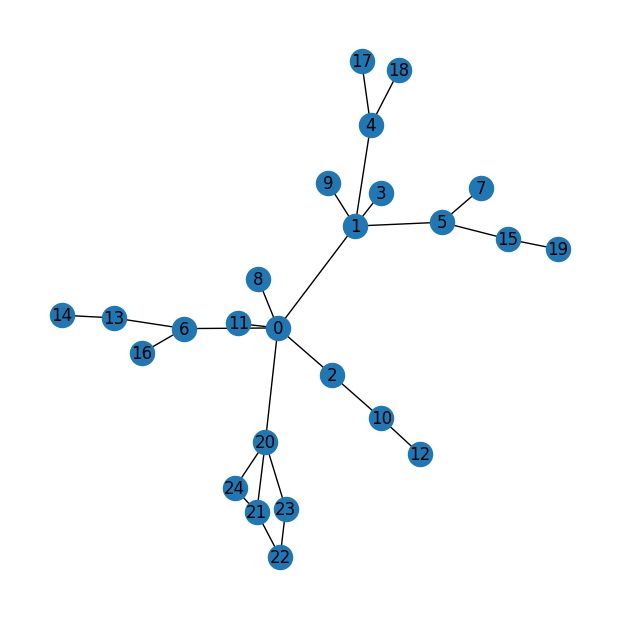

In [4]:
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, cmap="coolwarm", node_size=300)
plt.show()

### TRAINING GIN ###

In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GIN
import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn import global_mean_pool, global_max_pool

train_dataset, test_dataset, val_dataset = dataset[:800], dataset[800:900], dataset[900:]
print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Training set   = 800 graphs
Validation set = 100 graphs
Test set       = 100 graphs


In [6]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn.models import MLP

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels

        self.mlp = MLP([hidden_channels, hidden_channels, out_channels],
                       norm=None, dropout=0.5)

    def forward(self, x, edge_index, batch, batch_size, return_embeddings=False):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        
        node_embeddings = x 
        graph_embedding = global_add_pool(x, batch, size=batch_size)
        output = self.mlp(graph_embedding)
        
        if return_embeddings:
            return output, node_embeddings
        return output



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)

# Compile model into an optimized version
model = torch.compile(model, dynamic=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, data.batch_size)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.batch, batch_size=data.num_graphs)
            predictions.append(output.cpu())
    
    return torch.cat(predictions, dim=0)


@torch.no_grad()
def get_node_embeddings(loader):
    model.eval()
    all_embeddings = []
    for data in loader:
        data = data.to(device)
        _, node_embeddings = model(data.x, data.edge_index, data.batch, data.batch_size, return_embeddings=True)
        all_embeddings.append(node_embeddings.cpu())
    return torch.cat(all_embeddings, dim=0)

In [9]:
import time
times = []
for epoch in range(1, 101):
    start = time.time()
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Test: {test_acc:.4f}')
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 001, Loss: 0.5508, Train: 0.6238, Test: 0.5500
Epoch: 002, Loss: 0.1398, Train: 0.8113, Test: 0.7700
Epoch: 003, Loss: 0.0628, Train: 0.5737, Test: 0.5400
Epoch: 004, Loss: 0.0646, Train: 0.9962, Test: 1.0000
Epoch: 005, Loss: 0.0310, Train: 0.9938, Test: 1.0000
Epoch: 006, Loss: 0.1846, Train: 0.9925, Test: 0.9800
Epoch: 007, Loss: 0.0635, Train: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.0120, Train: 0.9988, Test: 1.0000
Epoch: 009, Loss: 0.0100, Train: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.0064, Train: 1.0000, Test: 1.0000
Epoch: 011, Loss: 0.0124, Train: 1.0000, Test: 1.0000
Epoch: 012, Loss: 0.0064, Train: 1.0000, Test: 1.0000
Epoch: 013, Loss: 0.0081, Train: 1.0000, Test: 1.0000
Epoch: 014, Loss: 0.0082, Train: 1.0000, Test: 1.0000
Epoch: 015, Loss: 0.0063, Train: 1.0000, Test: 1.0000
Epoch: 016, Loss: 0.0014, Train: 1.0000, Test: 1.0000
Epoch: 017, Loss: 0.0032, Train: 1.0000, Test: 1.0000
Epoch: 018, Loss: 0.0042, Train: 1.0000, Test: 1.0000
Epoch: 019, Loss: 0.0016, Tr

In [10]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [ ]:
data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions = predict(model, data_loader, device)

from sklearn.metrics import classification_report
y_true = [data.y.item() for data in test_dataset]
y_pred = predictions.argmax(dim=-1).numpy()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        53

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

